In [1]:
!pip install seaborn

In [26]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to calculate metrics for individual queries
def calculate_metrics_per_query(retrieved_lists, gold_lists):
    individual_metrics = {
        'Hits@10': [],
        'Hits@4': [],
        'AP@10': [],
        'RR@10': [],
        'RPrec@10': []
    }
    
    for retrieved, gold in zip(retrieved_lists, gold_lists):
        hits_at_10_flag = False
        hits_at_4_flag = False
        average_precision_sum = 0
        first_relevant_rank = None
        find_gold = []
        relevant_count = 0
        
        gold = [item.replace(" ", "").replace("\n", "") for item in gold]
        retrieved = [item.replace(" ", "").replace("\n", "") for item in retrieved]

        for rank, retrieved_item in enumerate(retrieved[:11], start=1):
            if any(gold_item in retrieved_item for gold_item in gold):
                if rank <= 10:
                    hits_at_10_flag = True
                    if first_relevant_rank is None:
                        first_relevant_rank = rank
                    if rank <= 4:
                        hits_at_4_flag = True
                    # Compute precision at this rank for this query
                    count = 0
                    for gold_item in gold:
                        if gold_item in retrieved_item and not gold_item in find_gold:
                            count += 1
                            find_gold.append(gold_item)
                    precision_at_rank = count / rank
                    average_precision_sum += precision_at_rank
            relevant_count += 1

        # Calculate RPrec as the precision at |gold|
        rprec = len(find_gold) / len(gold) if len(gold) > 0 else 0
        
        # Store individual metrics for this query
        individual_metrics['Hits@10'].append(int(hits_at_10_flag))
        individual_metrics['Hits@4'].append(int(hits_at_4_flag))
        individual_metrics['AP@10'].append(average_precision_sum / min(len(gold), 10))
        individual_metrics['RR@10'].append(1 / first_relevant_rank if first_relevant_rank else 0)
        individual_metrics['RPrec@10'].append(rprec)
    return individual_metrics
    

# Updated main_eval to collect individual metrics
def main_eval(file_name):
    with open(file_name, 'r') as file:
        data = json.load(file)
        
    retrieved_lists = []
    gold_lists = []

    for d in data:
        if d['question_type'] == 'null_query':
            continue
        retrieved_lists.append([m['text'] for m in d['retrieval_list']])
        gold_lists.append([m['fact'] for m in d['gold_list']])
        
    # Calculate metrics per query
    return calculate_metrics_per_query(retrieved_lists, gold_lists)


# Function to calculate and print average metrics
def print_average_metrics(metrics, reranker_name):
    print(f'Average Metrics for {reranker_name}:')
    for metric, values in metrics.items():
        avg_value = sum(values) / len(values)
        if metric == "AP@10" or metric == "RR@10":
            print(f"M{metric}: {avg_value:.4f}")
        else:
            print(f"{metric}: {avg_value:.4f}")
    print('-' * 20)

def question_type_list(data_file):
    q_type_lists = []
    
    with open(data_file, 'r') as file:
        data = json.load(file)
        
    for d in data: 
        if d['question_type'] != 'null_query':
            q_type_lists.append(d['question_type'])

    return q_type_lists
            
# Assuming metrics from several rerankers
metrics_rankerA = main_eval('output/rankerA.json')
metrics_rankerB = main_eval('output/rankerB.json')
metrics_rerankerA = main_eval('output/rerankerA.json')
metrics_rerankerB = main_eval('output/rerankerB.json')
metrics_rerankerC = main_eval('output/rerankerC.json')
metrics_rerankerD = main_eval('output/rerankerD.json')

# Print average metrics for each reranker
print_average_metrics(metrics_rankerA, "Ranker A")
print_average_metrics(metrics_rankerB, "Ranker B")
print_average_metrics(metrics_rerankerA, "Reranker A")
print_average_metrics(metrics_rerankerB, "Reranker B")
print_average_metrics(metrics_rerankerC, "Reranker C")
print_average_metrics(metrics_rerankerD, "Reranker D")

Average Metrics for Ranker A:
Hits@10: 0.5348
Hits@4: 0.4018
MAP@10: 0.1408
MRR@10: 0.3299
RPrec@10: 0.2499
--------------------
Average Metrics for Ranker B:
Hits@10: 0.6896
Hits@4: 0.5463
MAP@10: 0.1997
MRR@10: 0.4520
RPrec@10: 0.3429
--------------------
Average Metrics for Reranker A:
Hits@10: 0.6204
Hits@4: 0.5410
MAP@10: 0.2149
MRR@10: 0.4936
RPrec@10: 0.2989
--------------------
Average Metrics for Reranker B:
Hits@10: 0.6253
Hits@4: 0.5525
MAP@10: 0.2175
MRR@10: 0.5009
RPrec@10: 0.3012
--------------------
Average Metrics for Reranker C:
Hits@10: 0.7419
Hits@4: 0.6519
MAP@10: 0.2620
MRR@10: 0.5878
RPrec@10: 0.3866
--------------------
Average Metrics for Reranker D:
Hits@10: 0.7490
Hits@4: 0.6661
MAP@10: 0.2687
MRR@10: 0.6029
RPrec@10: 0.3917
--------------------


In [27]:
# Combine the individual metrics into a DataFrame for plotting, excluding Hits@4 and Hits@10
metrics_data = {
    'Metric': [],
    'Value': [],
    'QuestionType': [],
    'Reranker': []
}

q_type = question_type_list('data/rag.json')

# Populate the DataFrame with individual metrics for each reranker, excluding Hits@4 and Hits@10
for reranker, metrics in [('rankerA', metrics_rankerA), 
                          ('rankerB', metrics_rankerB), 
                          ('rerankerA', metrics_rerankerA),
                          ('rerankerB', metrics_rerankerB),
                          ('rerankerC', metrics_rerankerC),
                          ('rerankerD', metrics_rerankerD)
                         ]:
    for metric, values in metrics.items():
        if metric not in ['Hits@10', 'Hits@4']:  # Exclude Hits@4 and Hits@10
            for i, value in enumerate(values):
                metrics_data['Metric'].append(metric)
                metrics_data['Value'].append(value)
                metrics_data['QuestionType'].append(q_type[i])
                metrics_data['Reranker'].append(reranker)

# Convert to a pandas DataFrame
df = pd.DataFrame(metrics_data)

In [28]:
df.head()

,Metric,Value,QuestionType,Reranker
0,AP@10,0.000000,inference_query,rankerA
1,AP@10,0.125000,inference_query,rankerA
2,AP@10,0.500000,inference_query,rankerA
3,AP@10,0.071429,comparison_query,rankerA
4,AP@10,0.500000,inference_query,rankerA


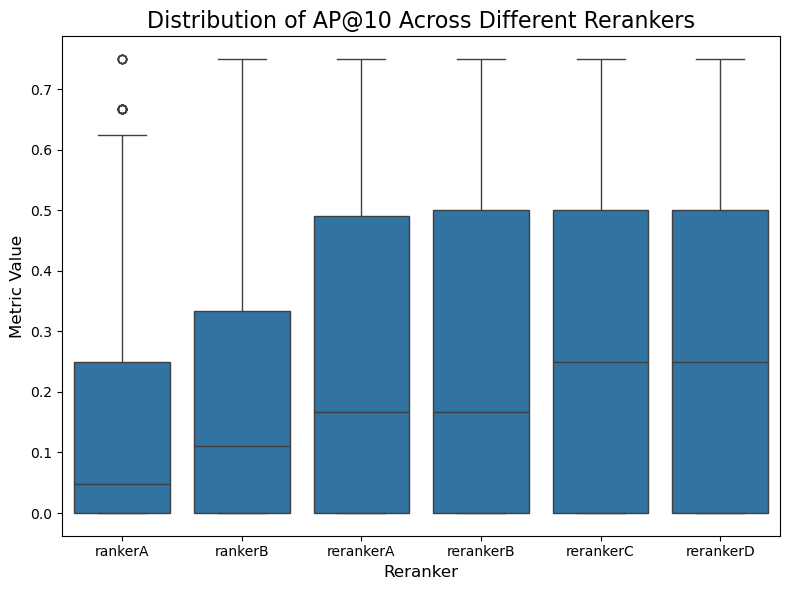

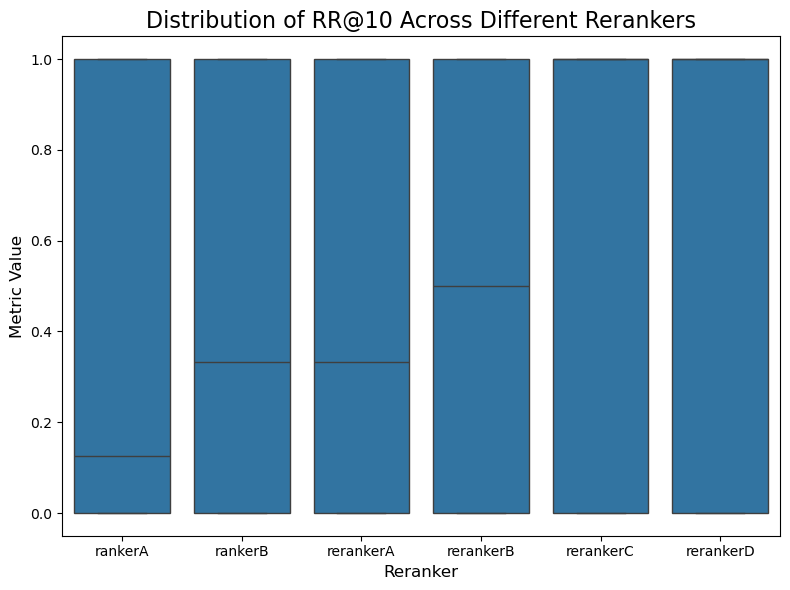

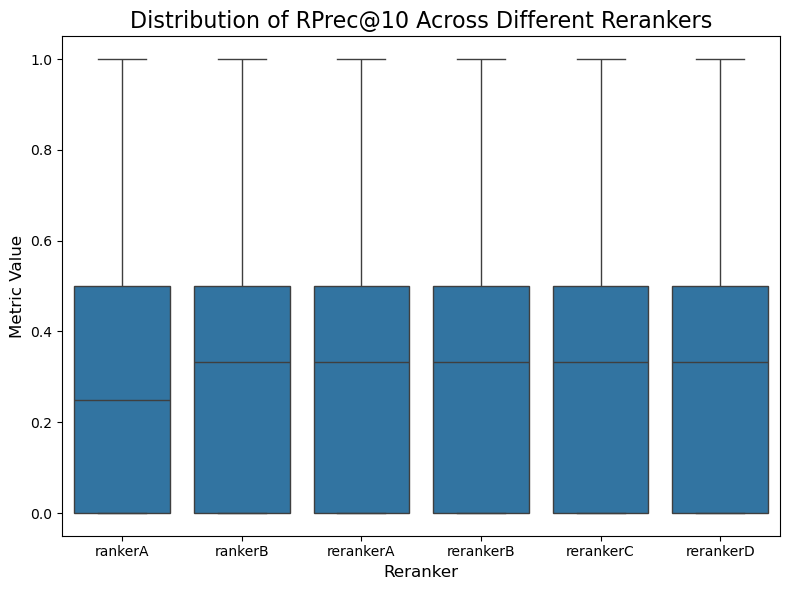

In [29]:
# List of metrics to plot
metrics_to_plot = ['AP@10', 'RR@10', 'RPrec@10']


# Generate a separate boxplot for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Reranker', y='Value', data=df[df['Metric'] == metric])
    
    # Customize the plot
    plt.title(f'Distribution of {metric} Across Different Rerankers', fontsize=16)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xlabel('Reranker', fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

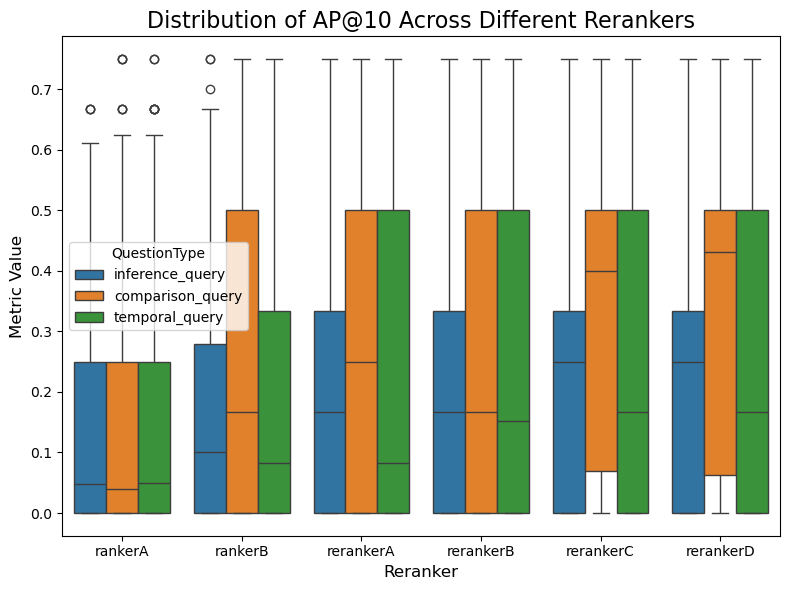

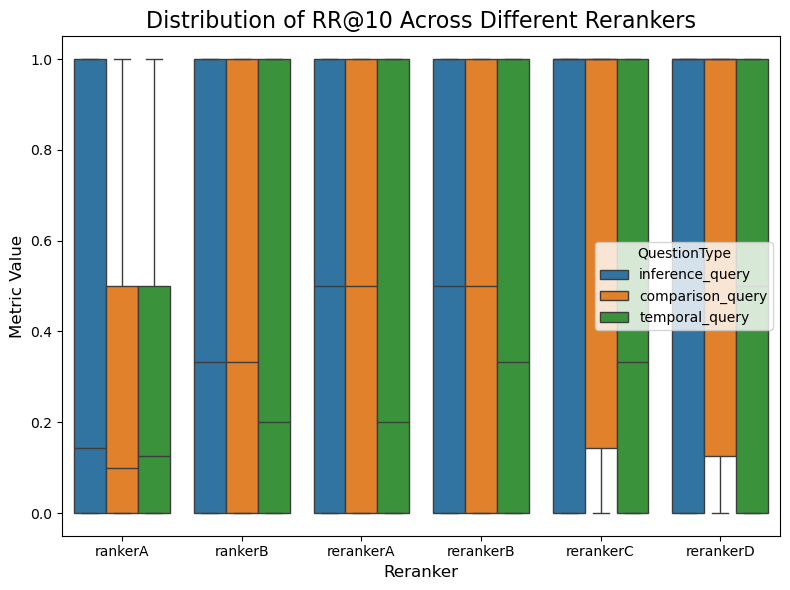

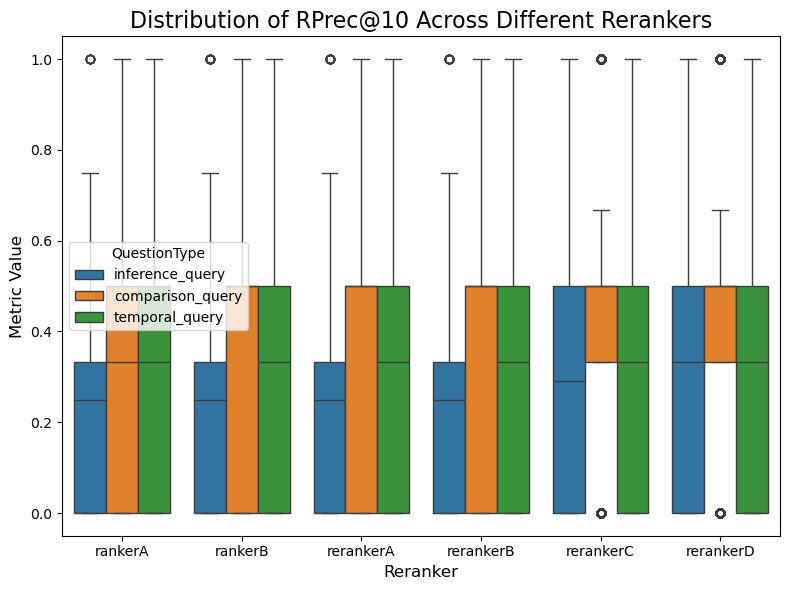

In [31]:
# List of metrics to plot
metrics_to_plot = ['AP@10', 'RR@10', 'RPrec@10']

# Generate a separate boxplot for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Reranker', y='Value', data=df[df['Metric'] == metric], hue=df['QuestionType'])
    
    # Customize the plot
    plt.title(f'Distribution of {metric} Across Different Rerankers', fontsize=16)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xlabel('Reranker', fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()